# 1. Problem Description & Motivation

Most robots are composed of 3 main parts:
- The Controller ‐ also known as the "brain" which is run by a computer program.
- Mechanical parts ‐ motors, pistons, grippers, wheels, and gears that make the robot move, grab, turn, and lift.
- Sensors ‐ to tell the robot about its surroundings.

For a robot to learn and carry out a task correctly, it needs to rely and integrate all 3 components effectively.
In our problem, we help robots recognize the floor surface they’re standing on using data collected from Inertial Measurement Units (IMU sensors).
*IMU sensor data* is collected while driving a small mobile robot over *different floor surfaces* on the university premises. The task is to **predict which one of the nine floor types (carpet, tiles, concrete) the robot is on using sensor data such as acceleration and velocity**.

## What is IMU?
IMU stands for Inertial Measurement Unit, which is an electronic device that measures and reports a body's specific force, angular rate, and sometimes the magnetic field surroundings the body, using a combination of [accelerometers](https://en.wikipedia.org/wiki/Accelerometer) and [gyroscopes](https://en.wikipedia.org/wiki/Gyroscope),  sometimes also [magnetometers](https://en.wikipedia.org/wiki/Magnetometers). With these 3 incorporated sensors, the IMU measures at least 3 different types of quantities:
1. 3D Orientation
2. Linear Acceleration
3. Angular Acceleration

# 2. Data Acquisition

The dataset that we will be using comes a [Kaggle Competition](https://www.kaggle.com/c/career-con-2019/data).
x_train/test.csv = the input data, covering 10 sensor channels and 128 measurements per time series plus three ID columns
- row_id: The ID for this row.

- series_id: ID number for the measurement series. Foreign key to y_train/sample_submission.

- measurement_number: Measurement number within the series.

y_train.csv = the surfaces for training set.

- series_id: ID number for the measurement series.

- group_id: ID number for all of the measurements taken in a recording session. Provided for the training set only, to enable more cross validation strategies.

- surface: the target for this competition.

# 3. Data Exploration

In [17]:
#%matplotlib notebook
%matplotlib inline


#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Import all data and labels
x_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')
x_test = pd.read_csv('./data/X_test.csv')

print('X_train has {} rows, {} columns.'.format(x_train.shape[0],x_train.shape[1]))
print('y_train has {} rows, {} columns.'.format(y_train.shape[0],y_train.shape[1]))
print('X_test has {} rows, {} columns.'.format(x_test.shape[0],x_test.shape[1]))

X_train has 487680 rows, 13 columns.
y_train has 3810 rows, 3 columns.
X_test has 488448 rows, 13 columns.


It seems that number of rows for X_train is different from y_train. Let us explore the data further.

In [18]:
#print(x_train.head())
#print(y_train.head())
#print(x_train.describe())
#print(y_train.describe())


Check for missing or repeated data: 0 missing data, 0 duplicated data

In [19]:
print(x_train.isnull().sum())
x_test.isnull().sum()
y_train.isnull().sum()

print(x_train.duplicated().value_counts())
print(y_train.duplicated().value_counts())


row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64
False    487680
dtype: int64
False    3810
dtype: int64


Sort and ensure data is in sampled order (measurement_number and series_id)
Store time series data in 3D array(series_id, time order, features)

In [20]:
x_train_sorted = x_train.sort_values(by = ['series_id', 'measurement_number'])
y_train_sorted = y_train.sort_values(by = ['series_id', 'group_id'])
print(x_train_sorted.head())
print(y_train_sorted.head())
col = x_train.columns.values #stores the feature names

  row_id  series_id  measurement_number  orientation_X  orientation_Y  \
0    0_0          0                   0       -0.75853       -0.63435   
1    0_1          0                   1       -0.75853       -0.63434   
2    0_2          0                   2       -0.75853       -0.63435   
3    0_3          0                   3       -0.75852       -0.63436   
4    0_4          0                   4       -0.75852       -0.63435   

   orientation_Z  orientation_W  angular_velocity_X  angular_velocity_Y  \
0       -0.10488       -0.10597            0.107650            0.017561   
1       -0.10490       -0.10600            0.067851            0.029939   
2       -0.10492       -0.10597            0.007275            0.028934   
3       -0.10495       -0.10597           -0.013053            0.019448   
4       -0.10495       -0.10596            0.005135            0.007652   

   angular_velocity_Z  linear_acceleration_X  linear_acceleration_Y  \
0            0.000767               -0.

In [31]:
a = np.zeros(((x_train.shape[0]//128),128,10)) #create 3D array [series_id][time_order][feature]
for j in range(a.shape[2]):
    for i in range(a.shape[0]):
        a[i,:,j]=x_train_sorted.ix[i*128:128*(i+1)-1, col[3+j]]


C:\Users\Admin\Miniconda3\envs\CE9010_2019\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [35]:
for j in range(a.shape[2]):
    for i in range(a.shape[0]):
        a[i,:,j]= (a[i,:,j]-np.mean(a[i,:,j]))/np.std(a[i,:,j])
        
    


NameError: name 'bzscore' is not defined

In [33]:
#display Min-Max of each feature for a 
def min_max_values(col):
    top = X_train[col].idxmax()
    top_obs = pd.DataFrame(X_train.loc[top])
    
    bottom = X_train[col].idxmin()
    bot_obs = pd.DataFrame(X_train.loc[bottom])
    
    min_max_obs = pd.concat([top_obs, bot_obs], axis = 1)
    
    return min_max_obs

['concrete', 'soft-pvc', 'wood', 'tiled', 'fine-concrete', 'hard-tiles-large-space', 'soft-tiles', 'carpet', 'hard-tiles']


<Figure size 432x288 with 0 Axes>

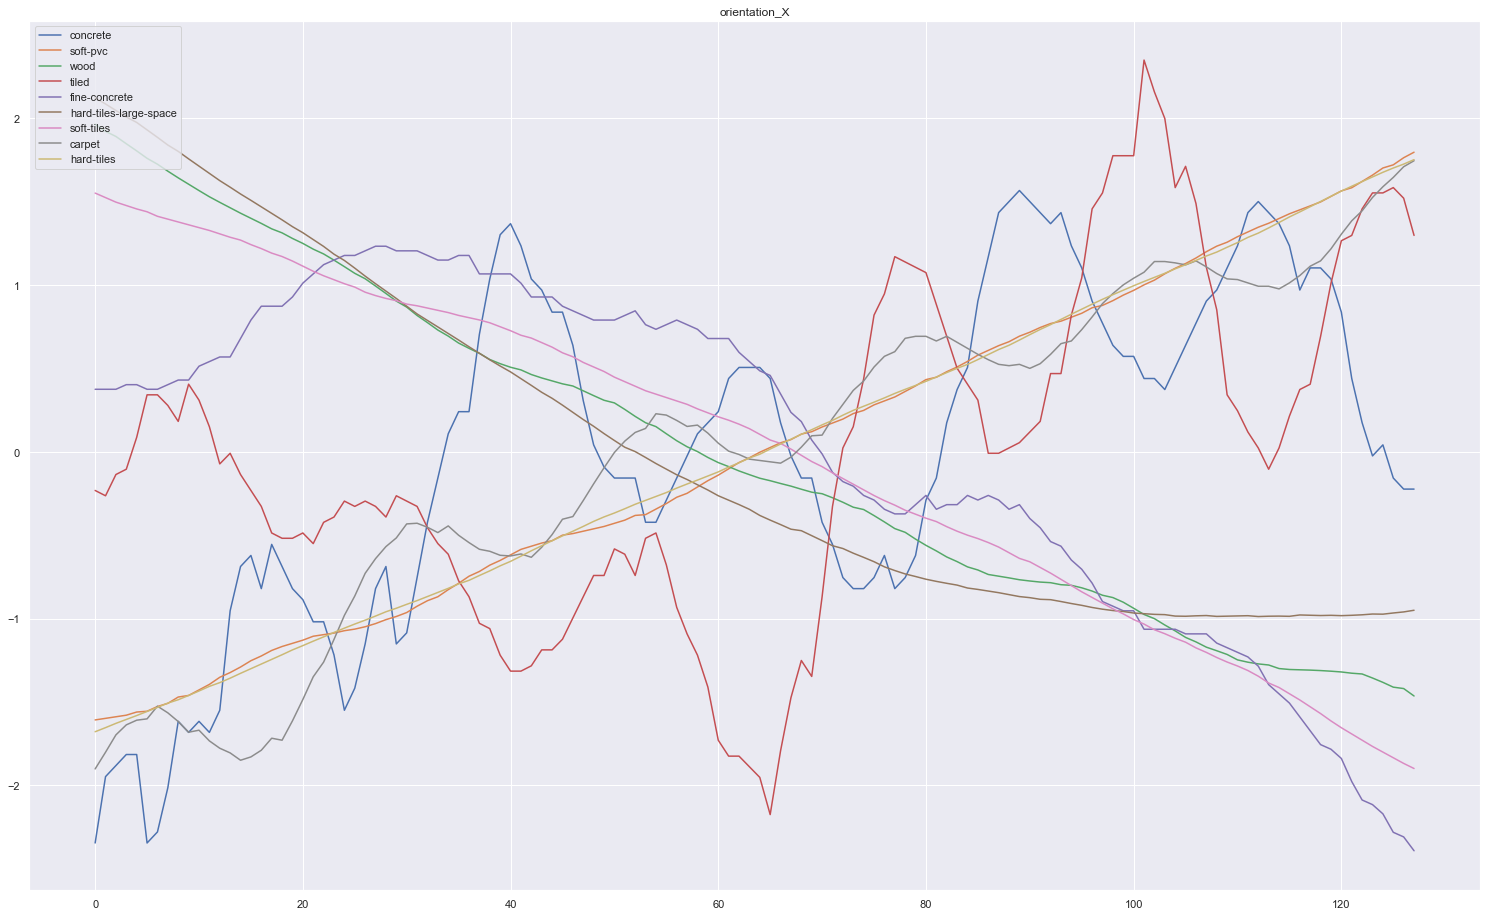

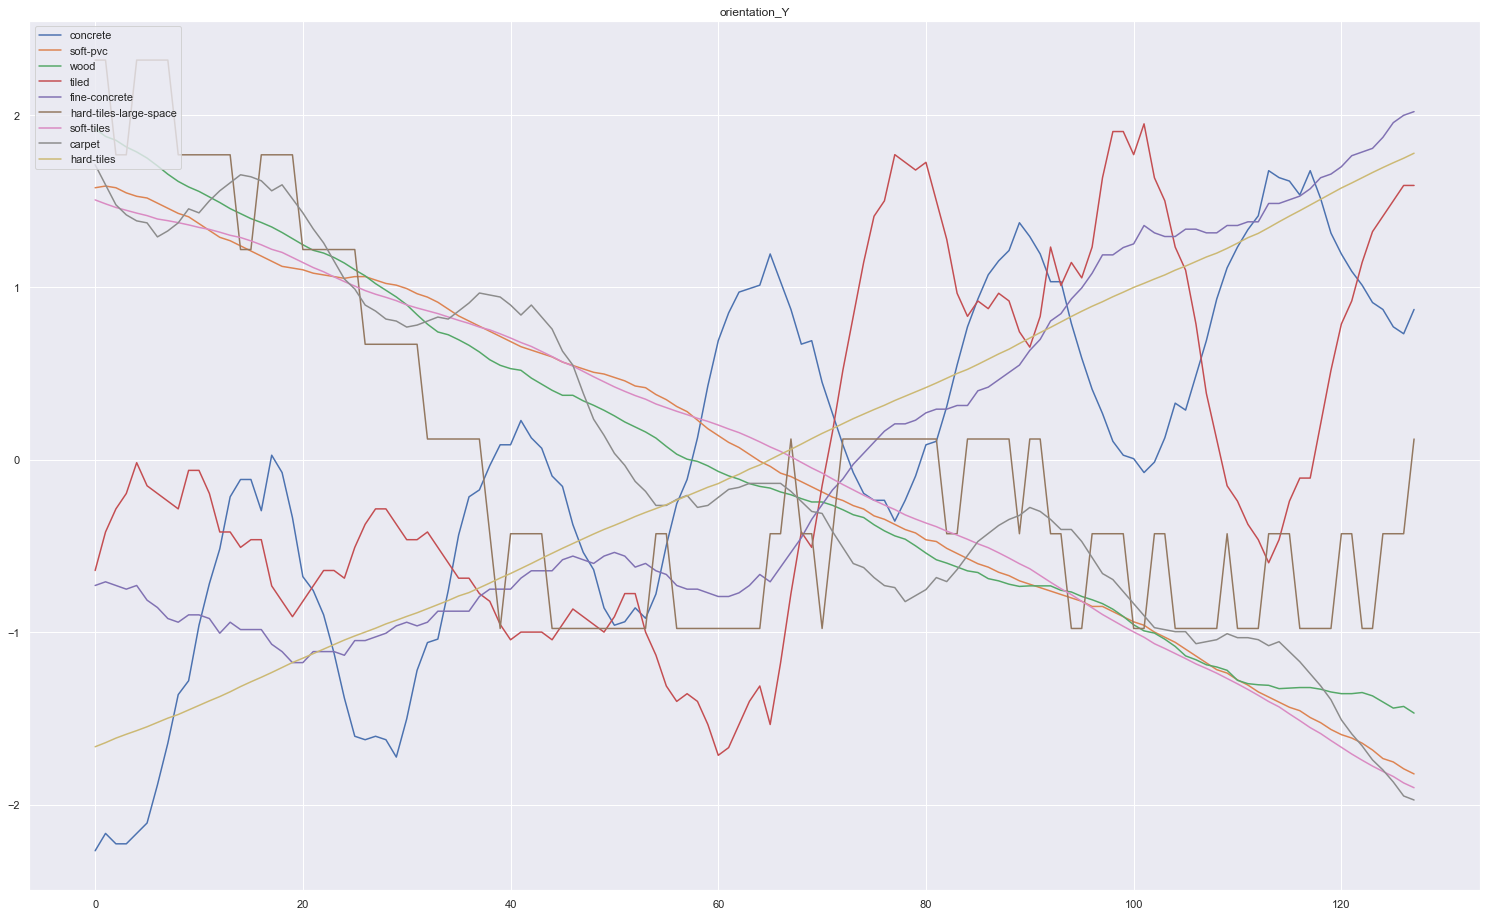

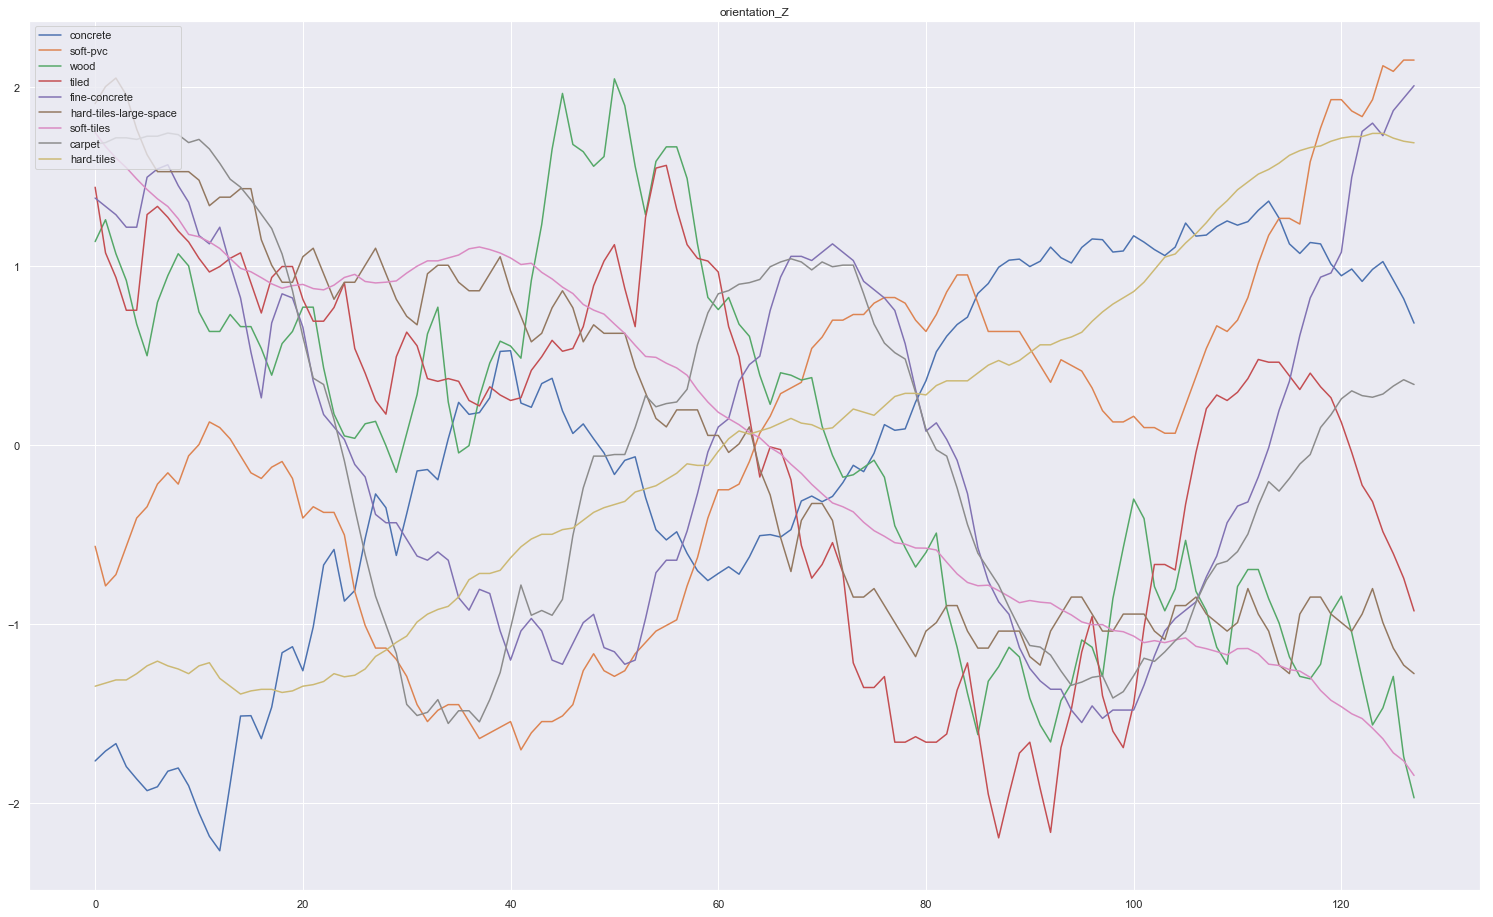

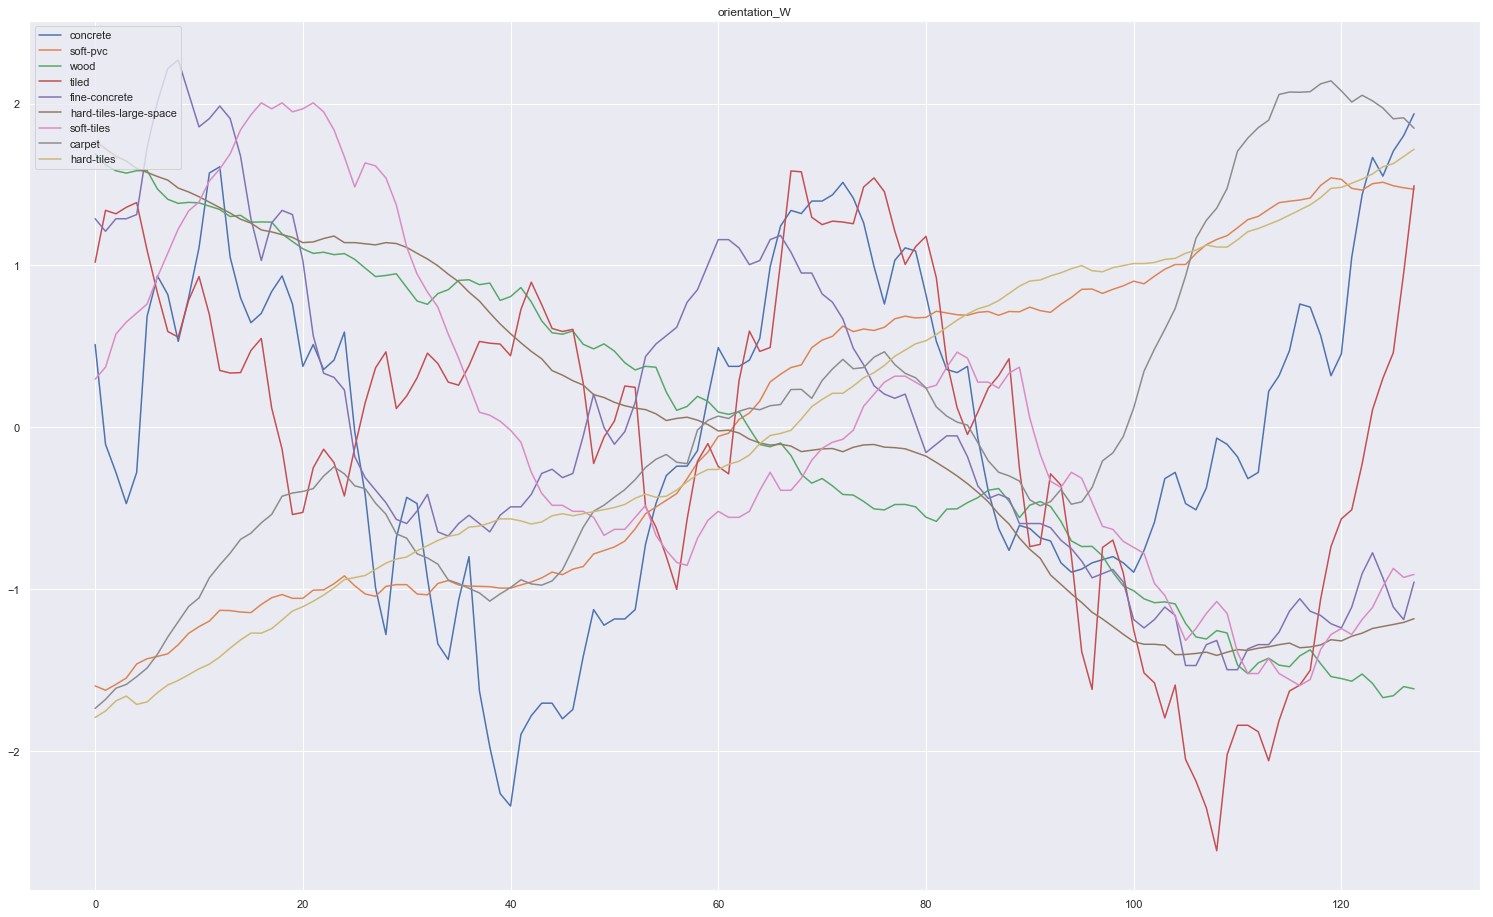

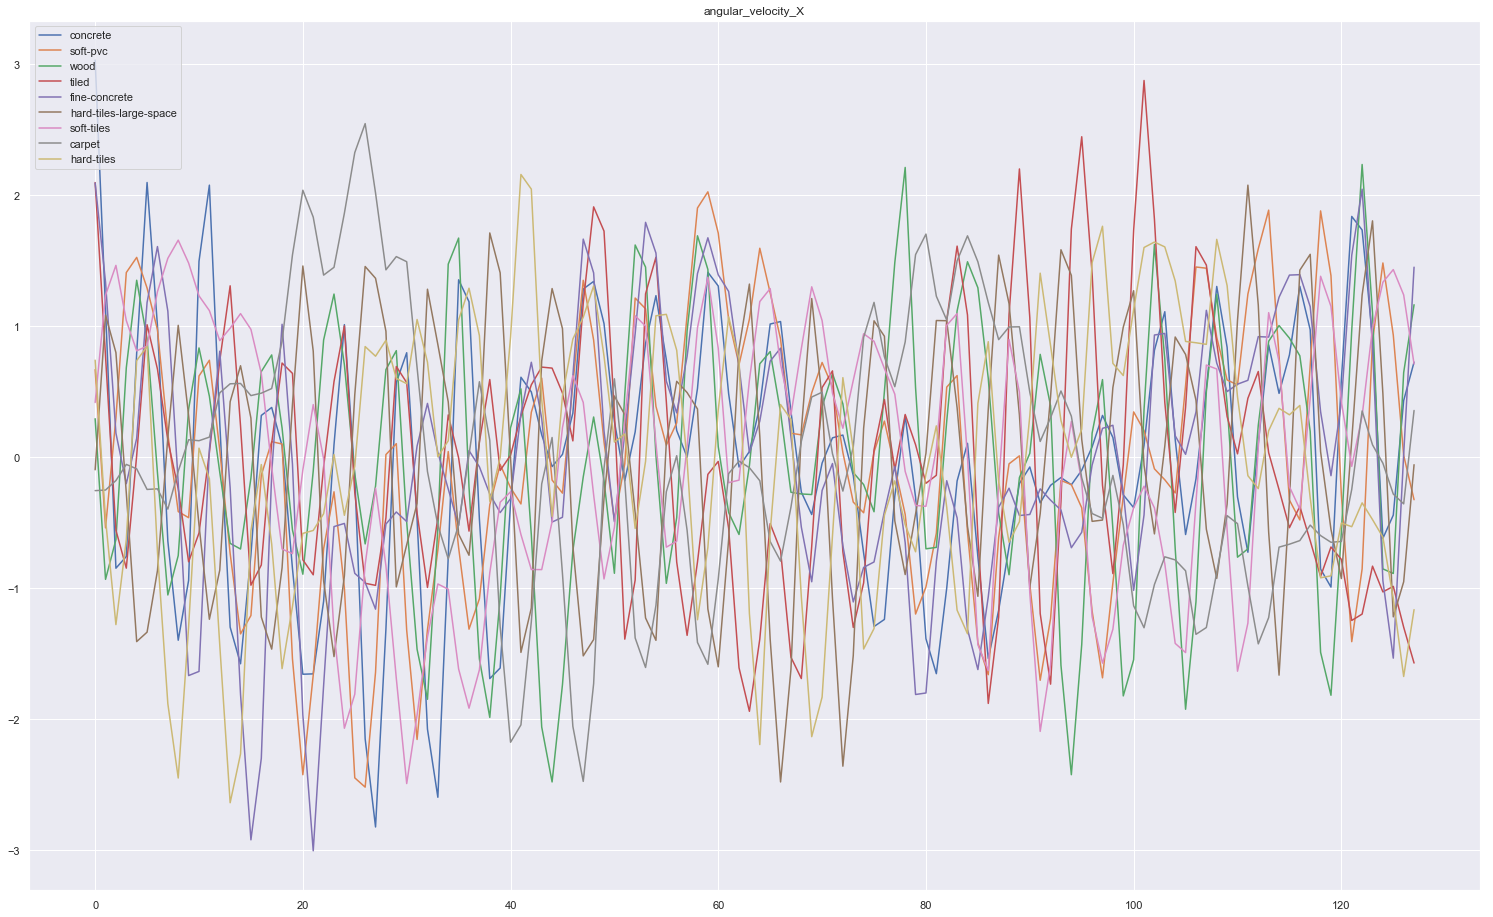

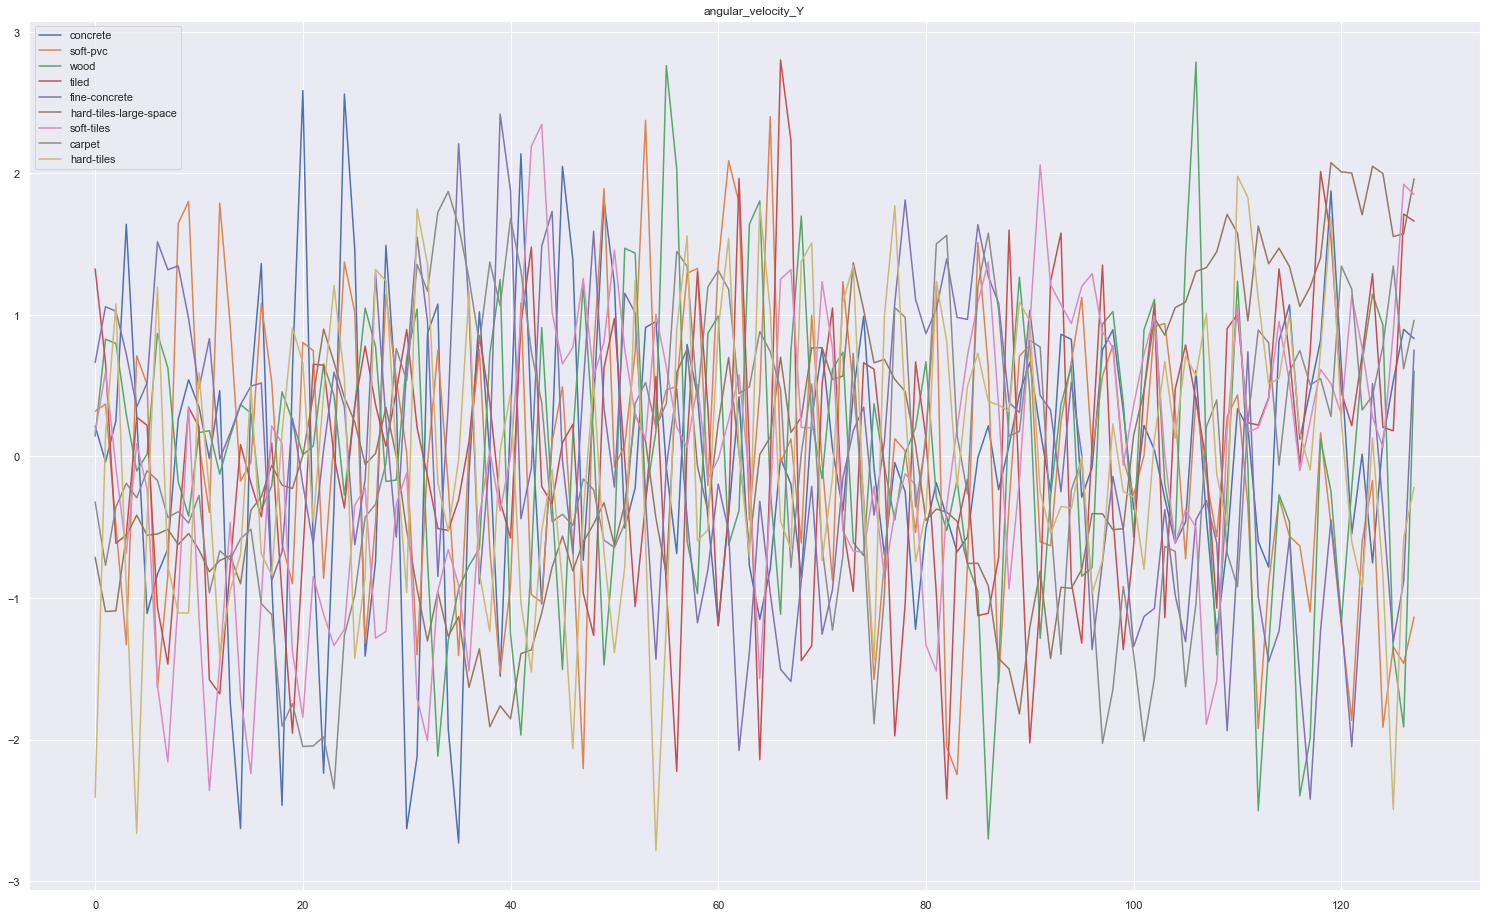

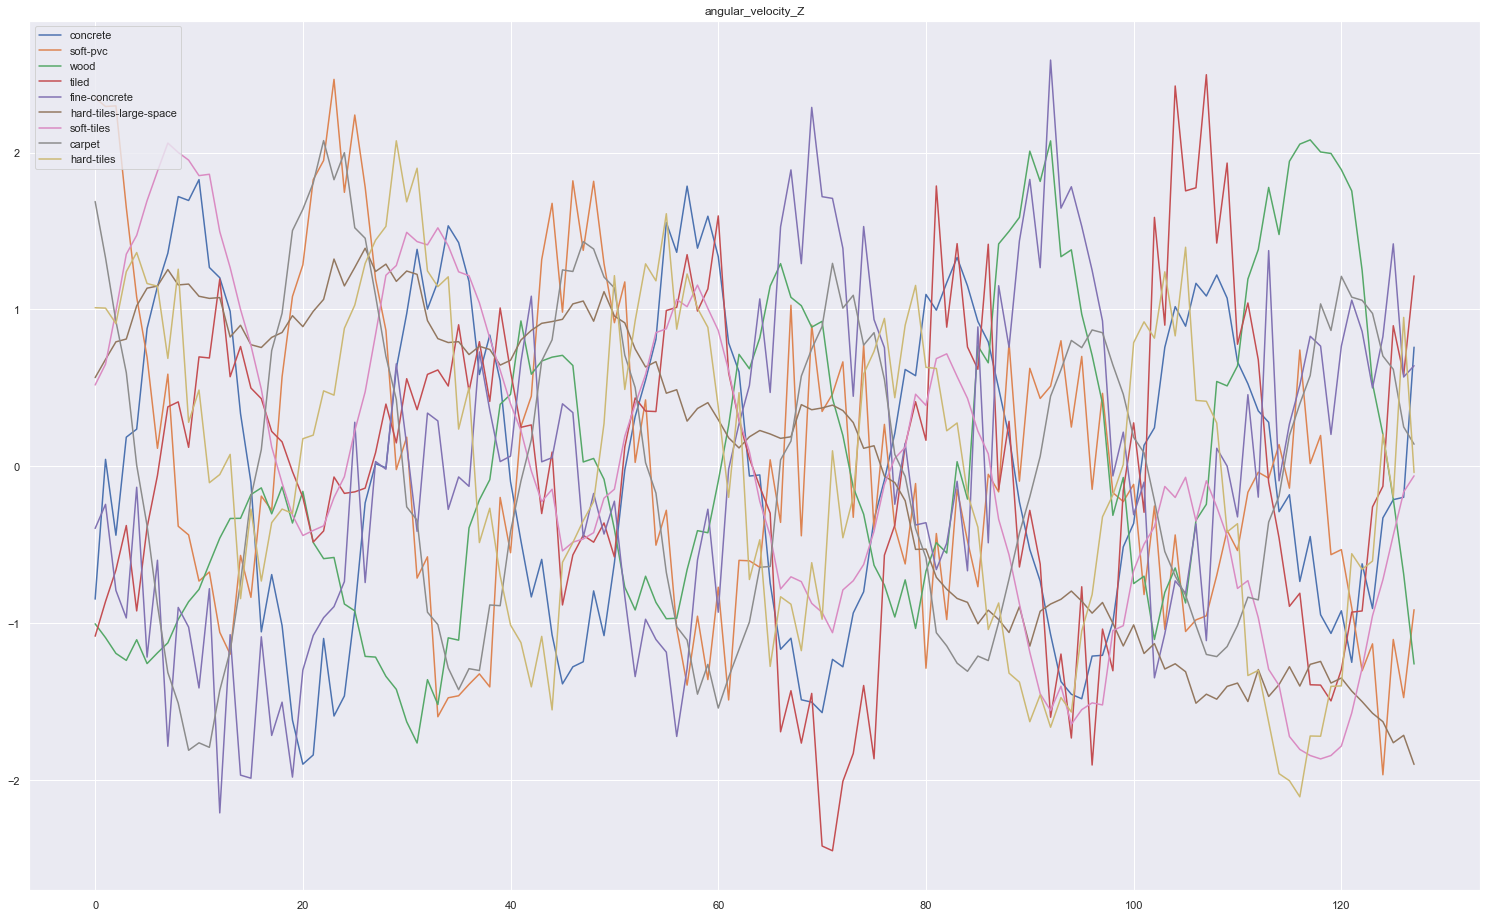

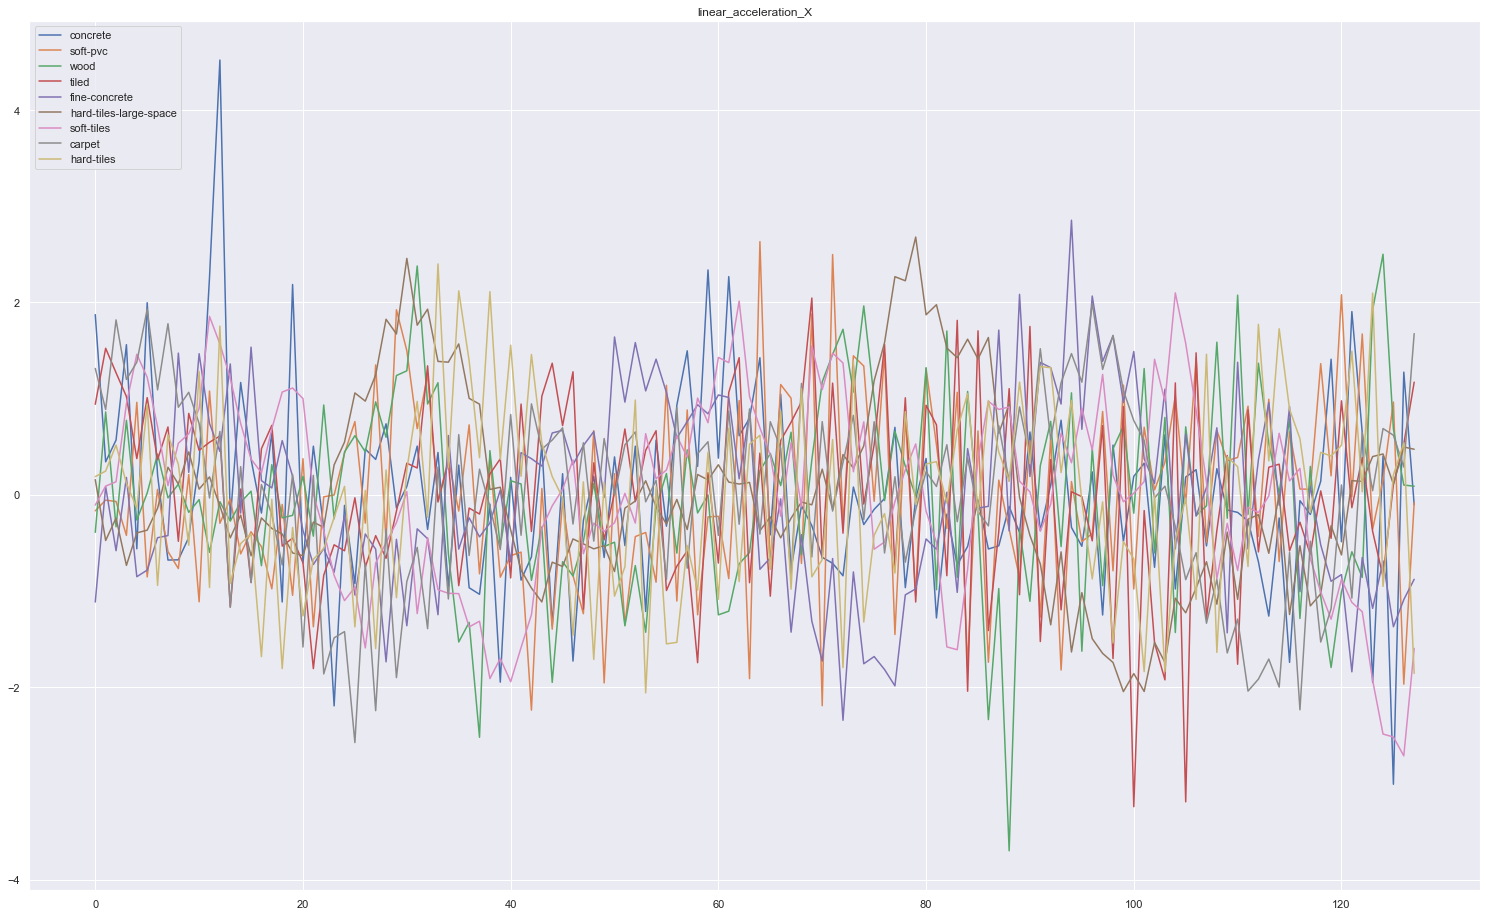

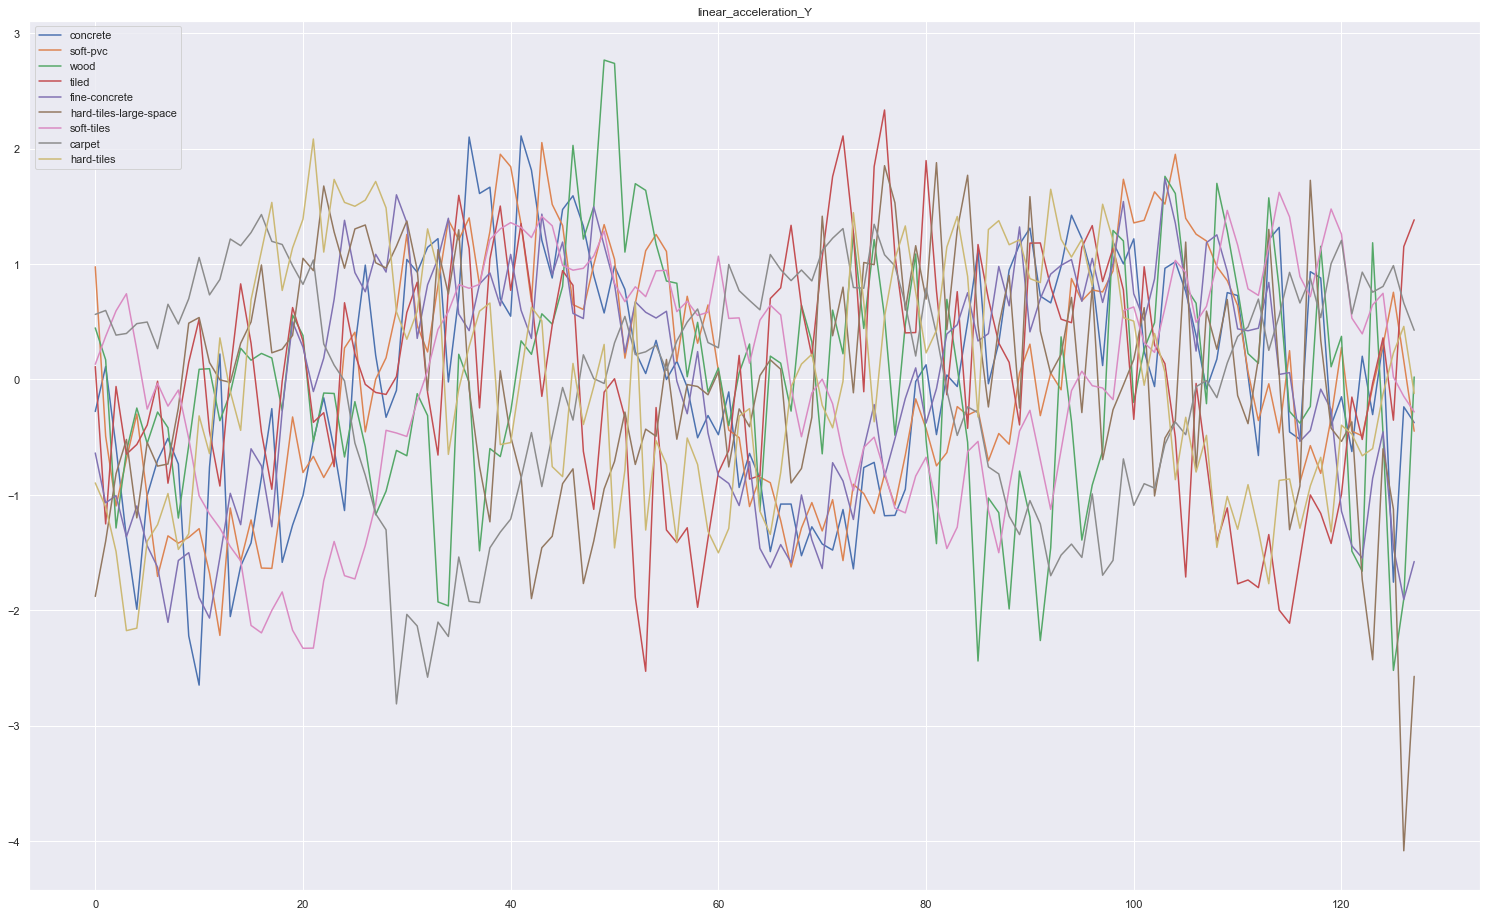

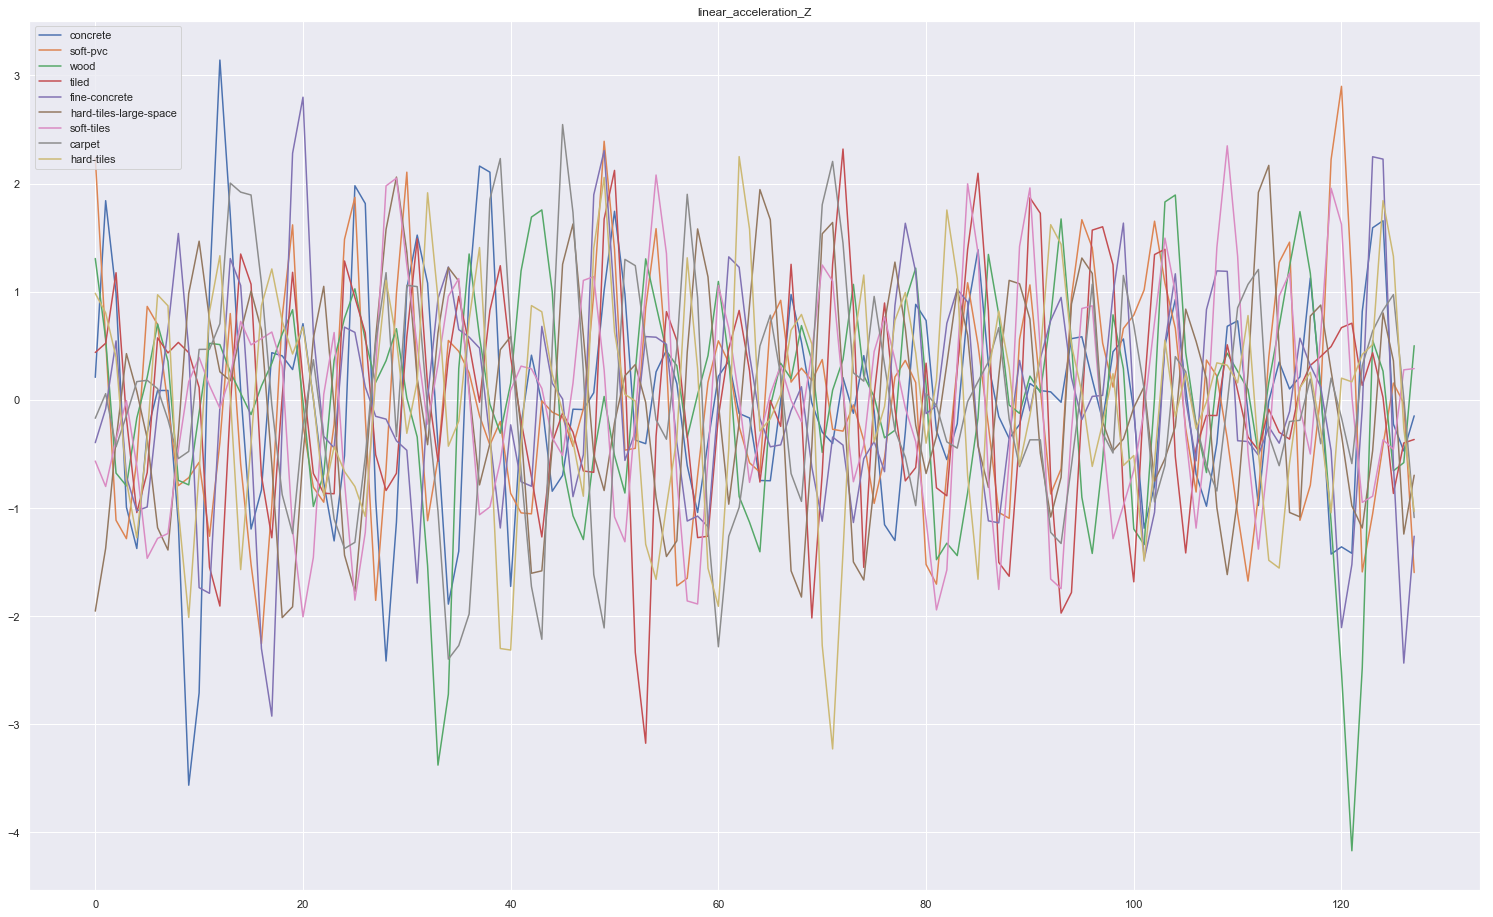

In [71]:
#plot data to see time series
#print(a[0,0:128,0])
time_order = [x for x in range(128)]
y_example_surface = [1,6,41,5, 0, 8,4,12,27]
y_labels = list(y_train['surface'].value_counts().index)
y_labels = [y_label.replace('_','-') for y_label in y_labels]
print(y_labels)

plt.figure()
count = -1
for j in range(10):
    plt.figure(figsize=[26,16])
    plt.title(col[j+3])
    for i in y_example_surface:
        if i == 1:
            count = -1
        plt.plot(time_order,a[i,:,j],label='1')
        count += 1
        
    plt.legend(y_labels,loc='upper left')







['concrete', 'soft_pvc', 'wood', 'tiled', 'fine_concrete', 'hard_tiles_large_space', 'soft_tiles', 'carpet', 'hard_tiles']


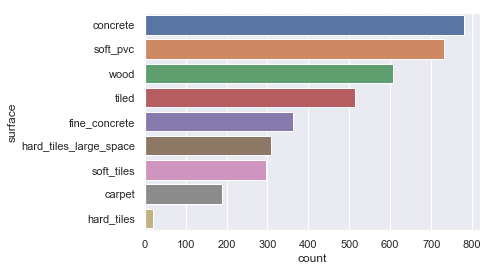

In [69]:
y_labels = list(y_train['surface'].value_counts().index)
sns.set(style='darkgrid')
sns.countplot(y = 'surface',
              data = y_train,
              order = y_labels)
print(y_labels)

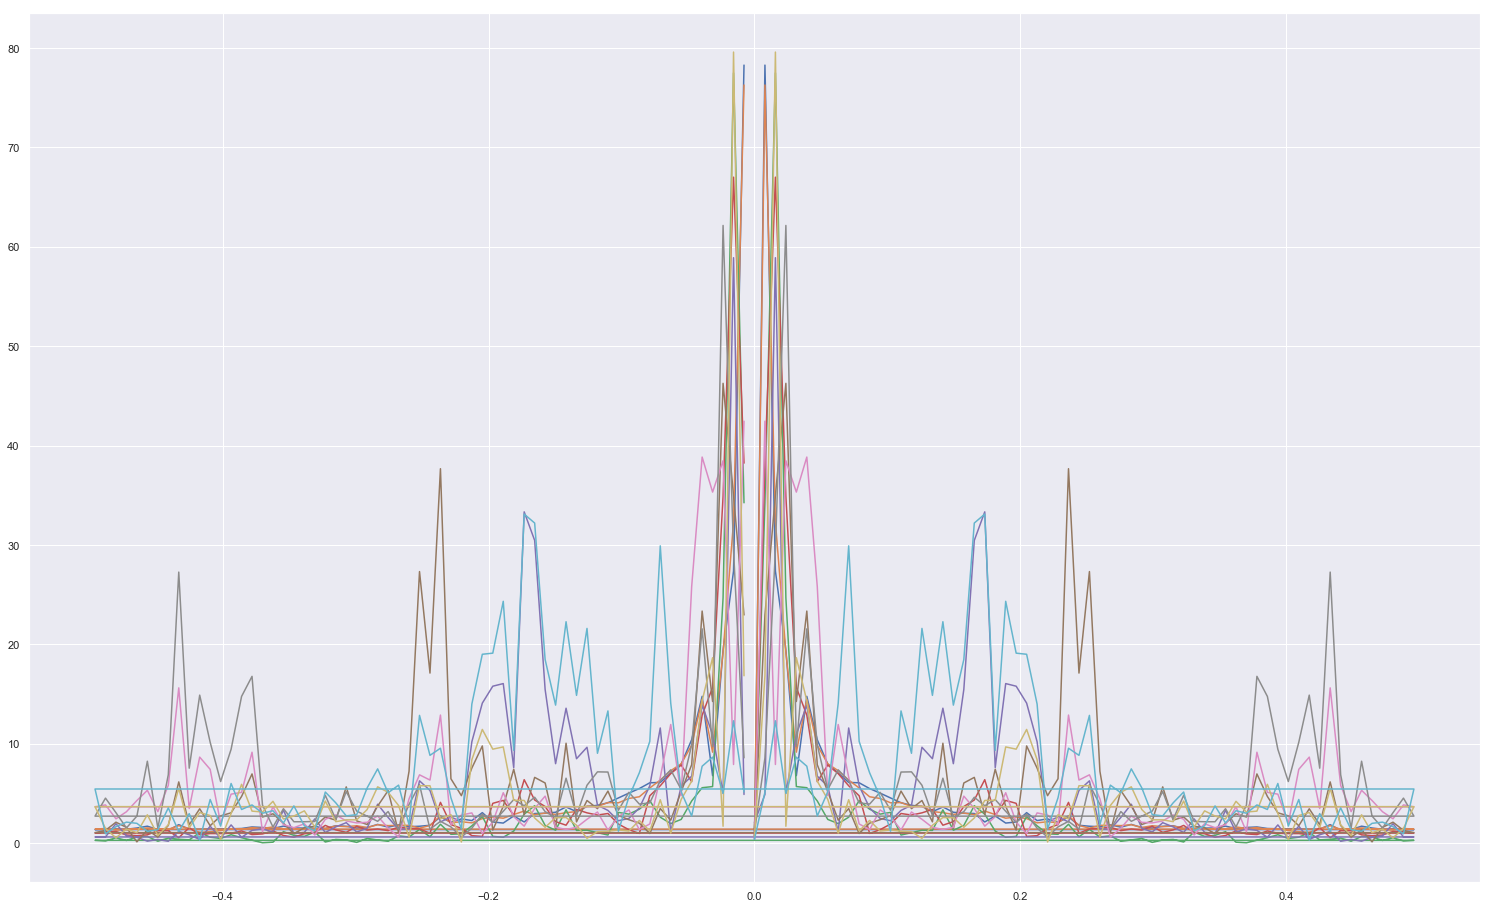

In [80]:
freq = np.fft.fftfreq(127)
plt.figure(figsize = [26,16])
for i in range(10):                      
    amp = np.abs(np.fft.fft(a[0,1:,i]))
    plt.plot(freq, amp)
# plt.xlim((0,0.1))



Text(0.5, 1.0, 'x_train Features Correlation Heat Map')

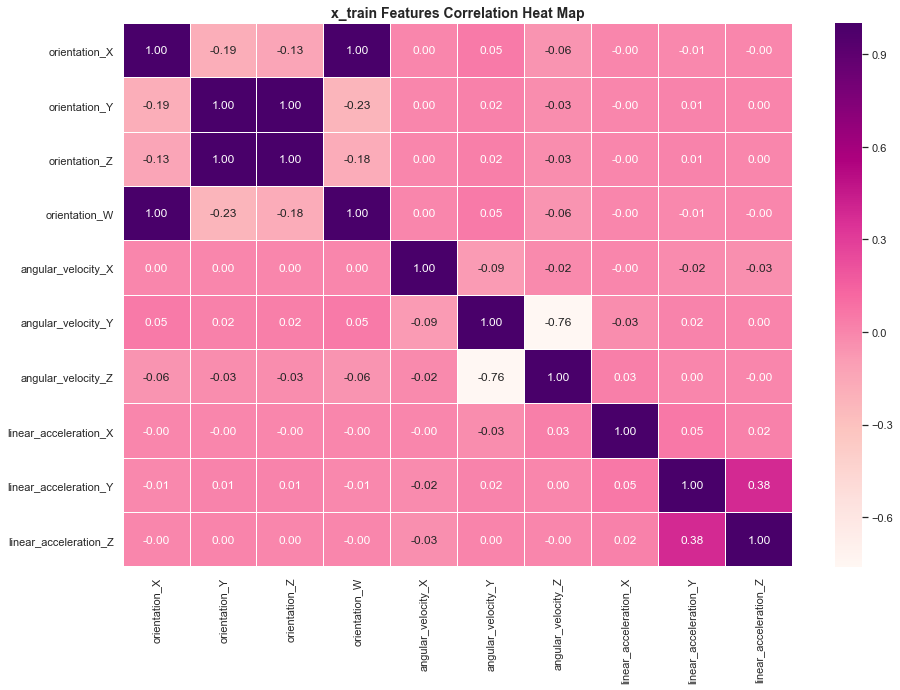

In [23]:
corr = x_train.corr()
corr

figure, axes = plt.subplots(1,1, figsize = (15,10))

heatmap = sns.heatmap(x_train.iloc[:,3:].corr(), ax = axes, cmap = 'RdPu', annot = True, fmt = '.2f', linewidths = 0.01)
heatmap.set_title('x_train Features Correlation Heat Map', fontsize=14, fontweight='bold')

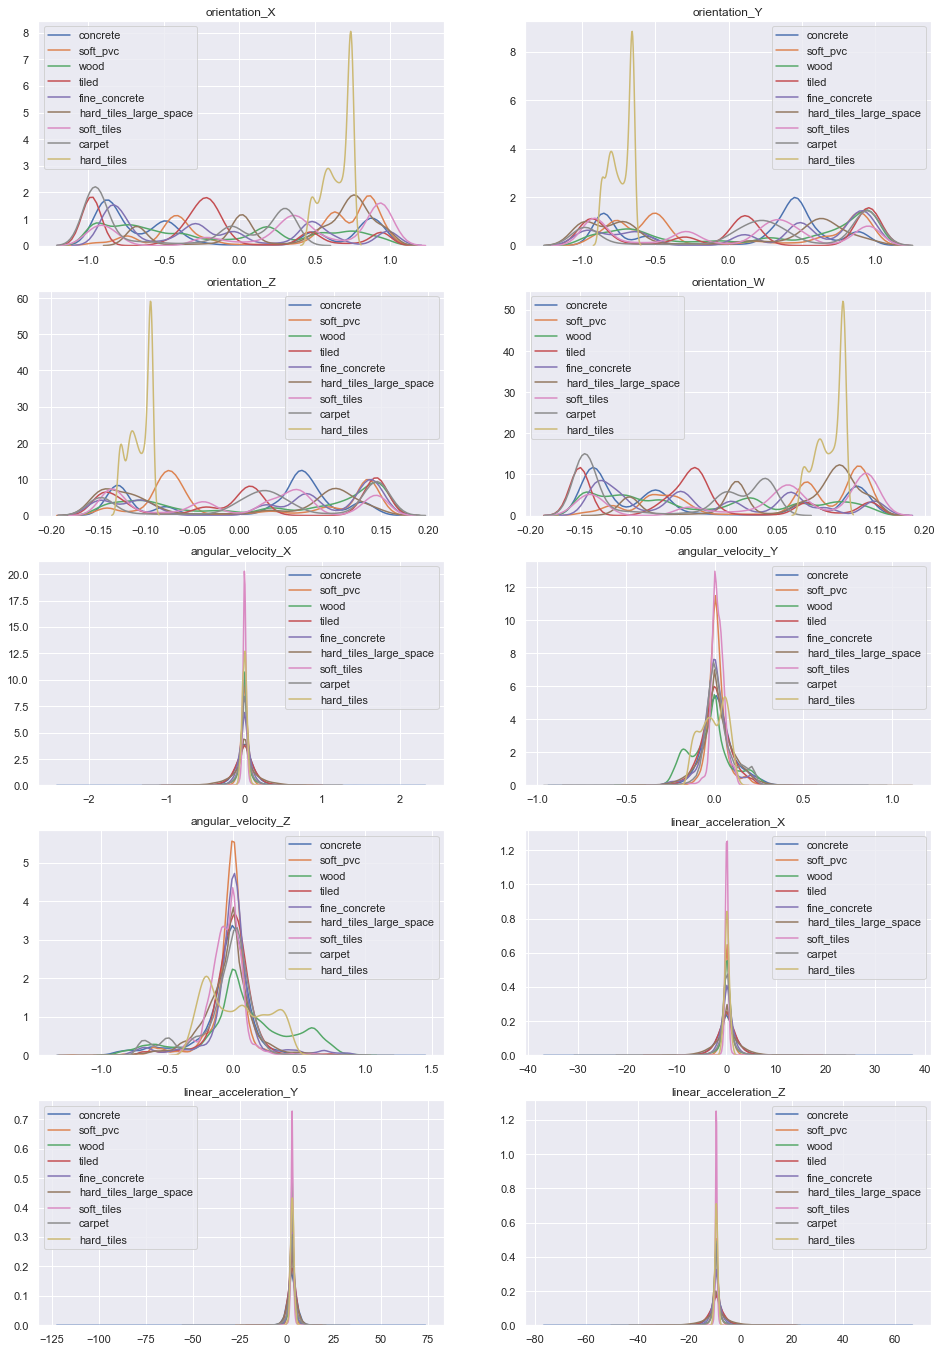

In [24]:
#plotting Kernel Distribution E
tmp = x_train.merge(y_train, on = 'series_id', how = 'inner')

plt.figure(figsize=(16, 24))
for index,column in enumerate(x_train.columns[3:13]): #return coord
    plt.subplot(5,2,index+1)
    plt.title(column)
    for surface in y_labels:
        surface_feature = tmp[tmp['surface'] == surface]
        sns.kdeplot(surface_feature[column], label = surface)


# 4. Data Preprocessing